In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

import models.fcnn as models_fcnn
import data_utils.data_analysis as data_analysis
import data_utils.pulse as pulse

In [2]:
#time in fs (it is the boundary)
def pulse_reconst_single(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=100):
    t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
    p_list=[]
    #for i in range(0,len(df_spec_freq)):
    intensity=df_spec_int#.loc[i].to_numpy()
    frequency=df_spec_freq#.loc[i].to_numpy()
    phase=df_spec_phase#.loc[i].to_numpy()
    p = pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
    p_list.append(p.intensity)
    
    return t,pd.DataFrame(p_list)

In [3]:
#time in fs (it is the boundary)
def pulse_reconst(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=100):
    t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
    p_list=[]
    for i in range(0,len(df_spec_int[:,0])):
        intensity=df_spec_int[i,:]#.loc[i].to_numpy()
        frequency=df_spec_freq#.loc[i].to_numpy()
        phase=df_spec_phase[i,:]#.loc[i].to_numpy()
        p = pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
        p_list.append(p.intensity)
    
    return t,pd.DataFrame(p_list)

## LOAD DATASET

In [4]:
filename='datasets/galadriel_dataset_24_09_18_high_res.h5'
df_input,df_time_val,df_time,df_freq_val,df_freq_int = data_analysis.read_dataset(filename)

Input DF
      shot number   order2   order3     order4  goodness
0          163165  34400.0 -23000.0 -5500000.0  0.945039
1          163166  34400.0 -23000.0 -5500000.0  0.862834
2          163167  34400.0 -23000.0 -5500000.0  0.834347
3          163168  34400.0 -23000.0 -5500000.0  0.873099
4          163169  34400.0 -23000.0 -5500000.0  0.851336
...           ...      ...      ...        ...       ...
9498       172664  35400.0  28000.0 -4000000.0  1.031447
9499       172665  35400.0  28000.0 -4000000.0  1.031718
9500       172666  35400.0  28000.0 -4000000.0  1.009015
9501       172667  35400.0  28000.0 -4000000.0  1.199801
9502       172668  35400.0  28000.0 -4000000.0  1.241150

[9503 rows x 5 columns]
----
Time values
0    -104.962227
1     -94.466005
2     -83.969782
3     -73.473559
4     -62.977336
5     -52.481114
6     -41.984891
7     -31.488668
8     -20.992445
9     -10.496223
10      0.000000
11     10.496223
12     20.992445
13     31.488668
14     41.984891
15     52.

In [5]:
df_spec_freq=pd.read_hdf(filename,'df_spec_freq')
df_spec_int=pd.read_hdf(filename,'df_spec_int')
df_spec_phase=pd.read_hdf(filename,'df_spec_phase')

#### DROP SHOTS WITH LOW GOODNESS

In [6]:
goodness_val=1.3
df_input_reduced=df_input[df_input['goodness']>goodness_val]

good_shots_list=df_input_reduced.index.values
#print(good_shots_list)
#df_pulse_200_reduced=df_pulse_200.iloc[good_shots_list]
df_spec_freq_reduced=df_spec_freq.iloc[good_shots_list]
df_spec_int_reduced=df_spec_int.iloc[good_shots_list]
df_spec_phase_reduced=df_spec_phase.iloc[good_shots_list]

#reset the index
df_input_reduced.reset_index(inplace=True,drop=True)
#df_pulse_200_reduced.reset_index(inplace=True,drop=True)
df_spec_freq_reduced.reset_index(inplace=True,drop=True)
df_spec_int_reduced.reset_index(inplace=True,drop=True)
df_spec_phase_reduced.reset_index(inplace=True,drop=True)

In [7]:
#Keep only unique rows in df_spec_freq
df_spec_freq_reduced[~df_spec_freq_reduced.duplicated()]

,0,1,2,3,4,5,6,7,8,9,...,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021
0,333.033214,333.126435,333.219657,333.312878,333.4061,333.499321,333.592543,333.685764,333.778986,333.872207,...,427.373367,427.466589,427.55981,427.653032,427.746253,427.839475,427.932696,428.025918,428.119139,428.212361


In [8]:
freq_values=df_spec_freq_reduced[~df_spec_freq_reduced.duplicated()].iloc[0]
factor=3e8/1e12 #factor to convert frequency in Hz to wavelength in m
#print(factor)
wavelen_values=factor/freq_values # Convert frequency to wavelength in m
wavelen_values=wavelen_values*1e9  # Convert to nm
#print(wavelen_values)

Text(0.5, 0, 'Wavelength (nm)')

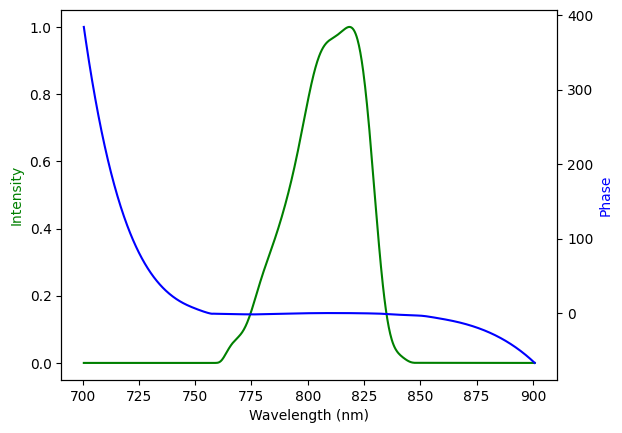

In [9]:
#plot random shot
shot_index=550
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(wavelen_values,df_spec_int_reduced.iloc[shot_index],color='g')
ax2.plot(wavelen_values,df_spec_phase_reduced.iloc[shot_index],color='b')
ax1.set_ylabel('Intensity',color='g')
ax2.set_ylabel('Phase',color='b')
ax1.set_xlabel('Wavelength (nm)')
#plt.title('Frequency spectrum')

In [10]:
#merge the intensity and phase dataframes to train a model with both
#df_spec_raw = pd.concat([df_spec_int_reduced, df_spec_phase_reduced], axis=1)

#### Create the dataset for training

In [11]:
#split the dataset (X:dazzler param, Y:wizzler) 
X=df_input_reduced[['order2','order3','order4']]
y_int=df_spec_int_reduced #Y for the intensity
y_phase=df_spec_phase_reduced #Y for the phase
X_train, X_test, y_int_train, y_int_test = train_test_split(X, y_int, test_size=0.3, random_state=101)
X_train, X_test, y_phase_train, y_phase_test = train_test_split(X, y_phase, test_size=0.3, random_state=101)

In [12]:
#split again the y_test into intensity and phase (if together)
#y_test_intesity = y_test.iloc[:,:len(y_test.columns)//2]
#y_test_phase = y_test.iloc[:,len(y_test.columns)//2:]

In [13]:

#y_test_intesity

## Modeling

In [14]:
class big_perceptron_fwd(nn.Module):
    def __init__(self,in_features,out_features):
        super().__init__()
        self.hidden1=nn.Linear(in_features,20*in_features)
        self.act1= nn.ReLU()
        self.hidden2=nn.Linear(20*in_features,100*in_features)
        self.act2=nn.ReLU()
        self.hidden3=nn.Linear(100*in_features,int(0.5*out_features))
        self.act3=nn.ReLU()
        self.hidden4=nn.Linear(int(0.5*out_features),int(0.8*out_features))
        self.act4=nn.ReLU()
        self.hidden5=nn.Linear(int(0.8*out_features),int(1.2*out_features))
        self.act5=nn.ReLU()
        self.hidden6=nn.Linear(int(1.2*out_features),int(1.2*out_features))
        self.act6=nn.ReLU()
        self.output=nn.Linear(int(1.2*out_features),out_features)

    def forward(self,x):
        x=self.act1(self.hidden1(x))
        x=self.act2(self.hidden2(x))
        x=self.act3(self.hidden3(x))
        x=self.act4(self.hidden4(x))
        x=self.act5(self.hidden5(x))
        x=self.act6(self.hidden6(x))
        x=self.output(x)
        return x

In [15]:
def train(X_train,X_test,y_train,y_test,
                n_epochs,batch_size,print_freq,learning_rate,device):
        #normalize the X (using the X_train)
        X_train_norm=models_fcnn.norm_data(X_train,X_train)
        X_test_norm=models_fcnn.norm_data(X_test,X_train) #normalized by the SAME values

        #convert data to tensors
        X_train_tensor=torch.tensor(X_train_norm.values,dtype=torch.float32)
        y_train_tensor=torch.tensor(y_train.values,dtype=torch.float32)

        X_test_tensor=torch.tensor(X_test_norm.values,dtype=torch.float32)
        y_test_tensor=torch.tensor(y_test.values,dtype=torch.float32)

        in_features=len(X_train.columns)
        out_features=len(y_train.columns)

        #define the model
        model=big_perceptron_fwd(in_features,out_features)

        #training
        trained_fcnn_model, train_error, test_error=models_fcnn.train_nn(X_train_tensor,y_train_tensor,X_test_tensor,y_test_tensor,
			model,device,n_epochs,batch_size,print_freq,learning_rate)
        return trained_fcnn_model, train_error, test_error

In [16]:
def predict(X_data,X_train,nn_fc_model,device):
        #normalize the X_data using the X_train
        X_data_norm=models_fcnn.norm_data(X_data,X_train)

        #convert it to tensor
        X_data_tensor=torch.tensor(X_data_norm.values,dtype=torch.float32)
        X_data_tensor=X_data_tensor.to(device)

        #make the prediction
        y_predict_tensor=nn_fc_model(X_data_tensor)
        y_predict_nn=y_predict_tensor.detach().cpu().numpy()
        
        #split in two: intensity and phase
        #y_predict_nn_intensity = y_predict_nn[:len(y_predict_nn) // 2]
        #y_predict_nn_phase = y_predict_nn[len(y_predict_nn) // 2:]
        return y_predict_nn#y_predict_nn_intensity, y_predict_nn_phase

In [17]:
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
print("We are using:",device)

We are using: cpu


### Model phase

In [18]:
trained_fcnn_model_phase, train_error, test_error = train(X_train, X_test, y_phase_train, y_phase_test,
                n_epochs=40, batch_size=64, print_freq=2, learning_rate=0.001, device=device)

Finished epoch 0,latest loss 10794.384765625
Finished epoch 2,latest loss 5736.234375
Finished epoch 4,latest loss 5168.95263671875
Finished epoch 6,latest loss 4922.69140625
Finished epoch 8,latest loss 4667.80419921875
Finished epoch 10,latest loss 4342.14208984375
Finished epoch 12,latest loss 4071.34326171875
Finished epoch 14,latest loss 3829.277587890625
Finished epoch 16,latest loss 3676.86181640625
Finished epoch 18,latest loss 3579.04736328125
Finished epoch 20,latest loss 3482.64697265625
Finished epoch 22,latest loss 3404.44189453125
Finished epoch 24,latest loss 3318.388916015625
Finished epoch 26,latest loss 3269.51611328125
Finished epoch 28,latest loss 3232.325439453125
Finished epoch 30,latest loss 3197.05419921875
Finished epoch 32,latest loss 3167.8271484375
Finished epoch 34,latest loss 3152.80029296875
Finished epoch 36,latest loss 3112.183837890625
Finished epoch 38,latest loss 3078.453369140625
Finished epoch 39,latest loss 3091.882080078125
Total time taken to tr

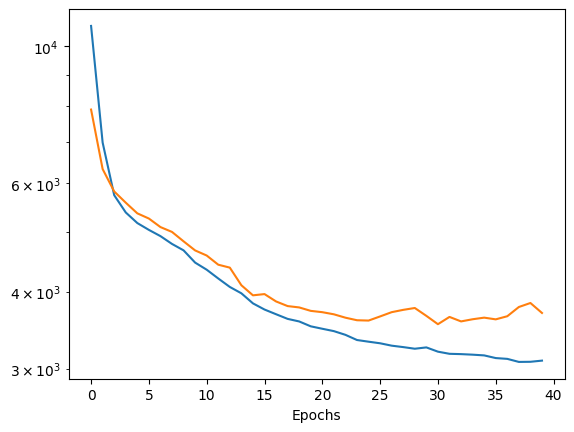

In [19]:
plt.plot(train_error, label='Train Error')
plt.plot(test_error, label='Test Error')
plt.xlabel('Epochs')
plt.yscale('log')

In [20]:
shot_index=50
X_s=X_test.iloc[shot_index]
y_predict_nn_phase = predict(X_s, X_train, trained_fcnn_model_phase, device)

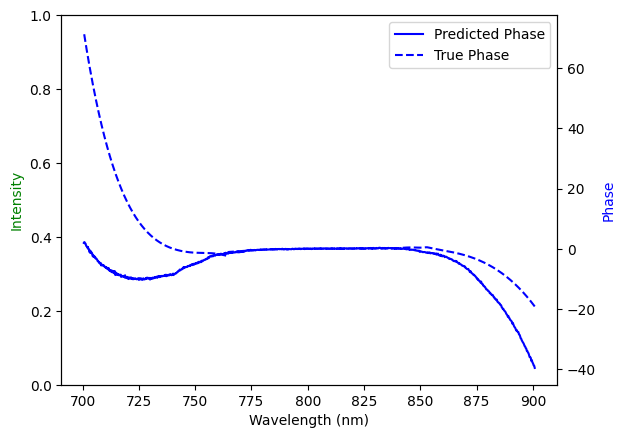

In [21]:

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
#ax1.plot(wavelen_values,y_predict_nn_intensity,color='g')
#ax1.plot(wavelen_values,y_test_intesity.iloc[shot_index],color='g',linestyle='--')
ax2.plot(wavelen_values,y_predict_nn_phase,color='b',label='Predicted Phase')
ax2.plot(wavelen_values,y_phase_test.iloc[shot_index],color='b',linestyle='--',label='True Phase')
ax1.set_ylabel('Intensity',color='g')
ax2.set_ylabel('Phase',color='b')
ax1.set_xlabel('Wavelength (nm)')
plt.legend()

## Model intensity

In [22]:
trained_fcnn_model_int, train_error, test_error = train(X_train, X_test, y_int_train, y_int_test,
                n_epochs=20, batch_size=64, print_freq=2, learning_rate=0.001, device=device)

Finished epoch 0,latest loss 0.058926038444042206
Finished epoch 2,latest loss 0.00515911215916276
Finished epoch 4,latest loss 0.0036835812497884035
Finished epoch 6,latest loss 0.0016018659807741642
Finished epoch 8,latest loss 0.0008516358211636543
Finished epoch 10,latest loss 0.0006794167566113174
Finished epoch 12,latest loss 0.0006099919555708766
Finished epoch 14,latest loss 0.0005752681754529476
Finished epoch 16,latest loss 0.000541812099982053
Finished epoch 18,latest loss 0.0005172400851733983
Finished epoch 19,latest loss 0.0005086049204692245
Total time taken to train the model: 8.92s


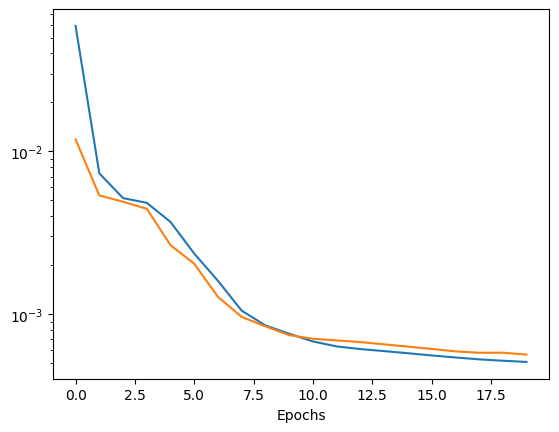

In [23]:
plt.plot(train_error, label='Train Error')
plt.plot(test_error, label='Test Error')
plt.xlabel('Epochs')
plt.yscale('log')

In [24]:
shot_index=18
X_s=X_test.iloc[shot_index]
y_predict_nn_int = predict(X_s, X_train, trained_fcnn_model_int, device)
y_predict_nn_phase = predict(X_s, X_train, trained_fcnn_model_phase, device)

In [25]:
#rescale the spectrum intensity to not be large than 1
y_predict_nn_int = y_predict_nn_int / np.max(y_predict_nn_int)
#set to zero the negative values
y_predict_nn_int[y_predict_nn_int < 0] = 0

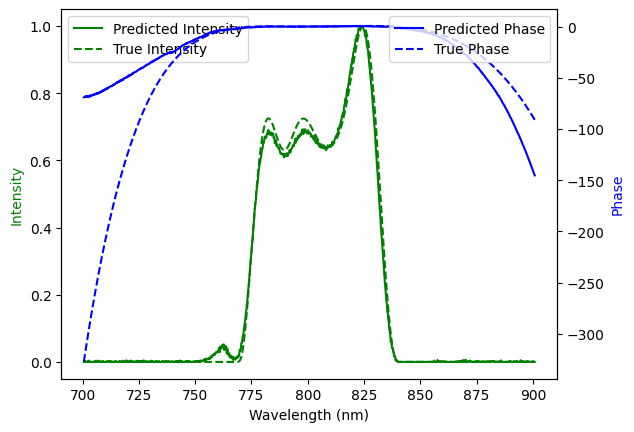

In [26]:

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(wavelen_values,y_predict_nn_int,color='g',label='Predicted Intensity')
ax1.plot(wavelen_values,y_int_test.iloc[shot_index],color='g',linestyle='--',label='True Intensity')
ax2.plot(wavelen_values,y_predict_nn_phase,color='b',label='Predicted Phase')
ax2.plot(wavelen_values,y_phase_test.iloc[shot_index],color='b',linestyle='--',label='True Phase')
ax1.set_ylabel('Intensity',color='g')
ax2.set_ylabel('Phase',color='b')
ax1.set_xlabel('Wavelength (nm)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

## Model pulse shape

In [27]:
filename_pulse='datasets/pulse_240918.h5'
#read the data
df_time_200=pd.read_hdf(filename_pulse,'df_time_200')
df_pulse_200=pd.read_hdf(filename_pulse,'df_pulse_200')
t_200=df_time_200.to_numpy()

### Drop shots with bad goodness

In [28]:
good_shots_list=df_input_reduced.index.values
#print(good_shots_list)
df_pulse_200_reduced=df_pulse_200.iloc[good_shots_list]

#reset the index
df_pulse_200_reduced.reset_index(inplace=True,drop=True)

In [29]:
#split the dataset (X:dazzler param, Y:wizzler) 
X=df_input_reduced[['order2','order3','order4']]
y=df_pulse_200_reduced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) #X is the same if random seed is the same

### TRain FWD MLP for pulse shape

In [30]:
forward_model_mlp=models_fcnn.FWmodelNN(X_train,y_train,X_test,y_test,device)
forward_model_mlp.train(200,#epochs 
                 128,#batch size
                 20, #print freq
                 0.001) #learning rate
y_predict_nn_fwd=forward_model_mlp.predict(X_test)
error_fwd_model_mlp=forward_model_mlp.error_calc_mae()

Finished epoch 0,latest loss 0.05191069841384888
Finished epoch 20,latest loss 0.004830056801438332
Finished epoch 40,latest loss 0.004594755358994007
Finished epoch 60,latest loss 0.004271914716809988
Finished epoch 80,latest loss 0.003825079882517457
Finished epoch 100,latest loss 0.003645943244919181
Finished epoch 120,latest loss 0.0035081550013273954
Finished epoch 140,latest loss 0.0033652831334620714
Finished epoch 160,latest loss 0.003210320370271802
Finished epoch 180,latest loss 0.0030015534721314907
Finished epoch 199,latest loss 0.0027477184776216745
Total time taken to train the model: 30.94s
Calculating the Mean Absolute Error


Text(0.5, 0, 'Epoch')

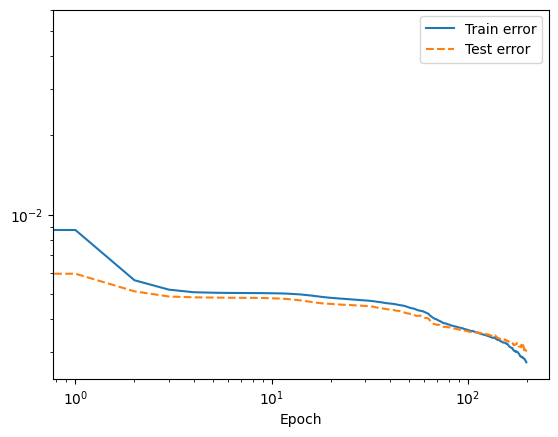

In [31]:
plt.plot(forward_model_mlp.train_error,label='Train error')
plt.plot(forward_model_mlp.test_error,linestyle='--',label='Test error')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Epoch')

In [32]:
shot_index=319
X_s=X_test.iloc[shot_index]
y_predict_nn_int = predict(X_s, X_train, trained_fcnn_model_int, device)
y_predict_nn_phase = predict(X_s, X_train, trained_fcnn_model_phase, device)
y_predict_nn_pulse=forward_model_mlp.predict(X_s)

In [33]:
#rescale the spectrum intensity to not be large than 1
y_predict_nn_int = y_predict_nn_int / np.max(y_predict_nn_int)
#set to zero the negative values
y_predict_nn_int[y_predict_nn_int < 0] = 0

In [34]:
#convert the series to numpy arrays and reconstruct the pulse from the spectrum
int_test_array=y_int_test.iloc[shot_index].to_numpy()
freq_values_array=freq_values.to_numpy()
phase_test_array=y_phase_test.iloc[shot_index].to_numpy()
t_200,df_pulse_exp=pulse_reconst_single(int_test_array,freq_values_array,phase_test_array,time=150,time_bins=200)
t_200,df_pulse_pred=pulse_reconst_single(y_predict_nn_int,freq_values_array,y_predict_nn_phase,time=150,time_bins=200)

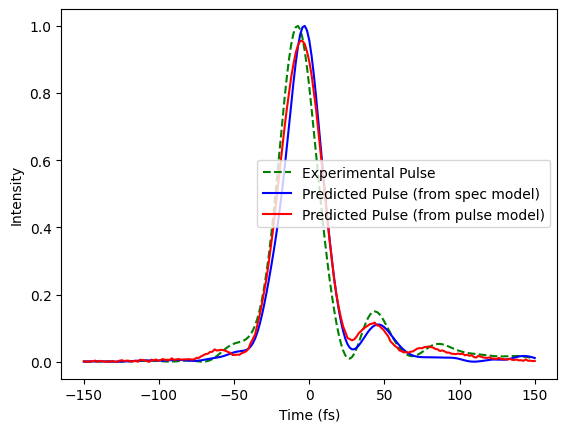

In [35]:
plt.plot(t_200,df_pulse_exp.iloc[0],label='Experimental Pulse',color='g',linestyle='--')
plt.plot(t_200,df_pulse_pred.iloc[0],label='Predicted Pulse (from spec model)',color='b')
plt.plot(t_200,y_predict_nn_pulse,label='Predicted Pulse (from pulse model)',color='r')
plt.xlabel('Time (fs)')
plt.ylabel('Intensity')
plt.legend()

### Calculate error distribution from the spec model

In [36]:
#first reconstruct the pulses from the spectrum intensity and phase from the prediction of the models

y_predict_nn_phase = predict(X_test, X_train, trained_fcnn_model_phase, device)
y_predict_nn_int = predict(X_test, X_train, trained_fcnn_model_int, device)
#rescale the spectrum intensity to not be large than 1
for i in range(len(y_predict_nn_int[:,0])):
    y_predict_nn_int[i,:] = y_predict_nn_int[i,:] / np.max(y_predict_nn_int[i,:])
#set to zero the negative values
y_predict_nn_int[y_predict_nn_int < 0] = 0


t_200,df_pulse_pred_spec=pulse_reconst(y_predict_nn_int,freq_values_array,y_predict_nn_phase,time=150,time_bins=200)

In [37]:
#reconstruct the pulse from the experimental (test) spectrum intensity and phase
t_200,df_pulse_test_spec=pulse_reconst(y_int_test.to_numpy(),freq_values_array,y_phase_test.to_numpy(),time=150,time_bins=200)

In [38]:
#study the erro distribution
mae_error_spec=abs(df_pulse_test_spec-df_pulse_pred_spec)
mae_error_spec=mae_error_spec.sum(axis=1)/df_pulse_test_spec.shape[1] #sum error / num columns

In [39]:
mae_error_spec

0      0.032239
1      0.014128
2      0.084909
3      0.039430
4      0.031486
         ...   
810    0.019391
811    0.015436
812    0.028385
813    0.042095
814    0.019103
Length: 815, dtype: float64

     Pulse model  Spectrum model
0       1.582672        3.223895
1       2.283766        1.412772
2       2.209545        8.490864
3       1.099100        3.942995
4       1.704029        3.148606
..           ...             ...
810     4.074023        1.939135
811     3.409062        1.543599
812     4.172964        2.838535
813     3.479554        4.209490
814     3.992003        1.910321

[815 rows x 2 columns]


(0.0, 5.0)

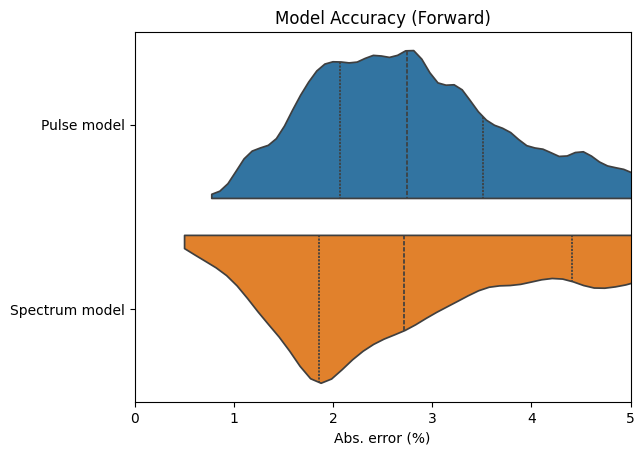

In [44]:
df_plot=pd.DataFrame({'Pulse model':100*error_fwd_model_mlp,
                      'Spectrum model':100*mae_error_spec})
#df_plot=pd.DataFrame({'RF':df_error_forward_rf})
print(df_plot)
sns.violinplot(data=df_plot,inner='quart',cut=0,bw_adjust=.4,split=True,orient='h')
plt.xlabel('Abs. error (%)')
plt.title('Model Accuracy (Forward)')
plt.xlim(0,5)